# Demo of cross-validation procedures: coach's demo, HWBCC, with SVM

This demo intend to illustrate some of ideas of cross-validation, with specific focus of the cv tools as impletmented through sklearn.

* I will use the HWBCC dataset because of our familiarity.
* I will use svm because of our familiarity.

>NOTE 1: Other classifiers that could easily be substituted at this point.
>Note 2: We will use standard scaler and the rbf kernel based on previous experience.


## Loading modules and data

I follow basically the same steps that we used to start the HW1 on the HWBCC dataset.  

We load relevent modules, along with the data.

In [3]:
# Module loads

import pandas as pd
import numpy as np
# use seaborn plotting defaults
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import sklearn.model_selection as ms

# scikit learn functions
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Basic parameter choices for grid search.
from sklearn.model_selection import GridSearchCV

## Read and parse, and preprocess the data 

* Create both `X` (predictors) and `y` (response).
* Split data into training and test sets.
* standarize the predictor variables

In [4]:
bcc = pd.read_csv("../data/dataR2.csv")

# We separate the date into the predictor variables and the response
X=bcc.loc[:,'Age':'MCP.1']
y=bcc.Classification

# specify random_state to allow reproducibility
X_train,X_test,y_train,y_test=train_test_split(
        X,y,test_size=0.25,random_state=23) 

#### With scaling

We first create scaled data

In [5]:
scaler_pd = StandardScaler().set_output(transform="pandas")

scaler_pd.fit(X_train) # fit the scaler to the test data

# scale both training and test data using the SAME SCALER
X_train_sc=scaler_pd.transform(X_train)
X_test_sc=scaler_pd.transform(X_test)


## Construct a baseline model (no cross-validation)

We will use C=10 (based on playing that we have done before) and other default settings to build a model.

This is meant to connect to previous work and establish reasonable parameter about which we will experiment.

The code below is similar to what we have used before, and does the following process steps:

* Instatiates the model 
* Fits to the training data
* Uses `predict` method to make predictions on the test set.
* Evaluates for accuracy, outputs a confusion matrix
* Prints the predictions on the test set
* creates a plot.

In [6]:
# A helper function for plotting
rng=np.random.default_rng(12345)
xvals = .7*rng.random(29)+X_test.Age-.35
def myplot(y_pred):
    plt.rcParams['figure.figsize'] = [10, 1.6]
    plt.style.use('bmh')
    plt.scatter(xvals,y_test)
    plt.scatter(xvals,y_pred,marker='x',s=50,linewidth=1)
    plt.show()

Scaled SVM Accuracy: 0.7241379310344828
[2 2 1 2 2 1 1 1 1 2 1 2 1 2 2 2 2 1 2 2 1 2 1 2 1 1 1 1 2]


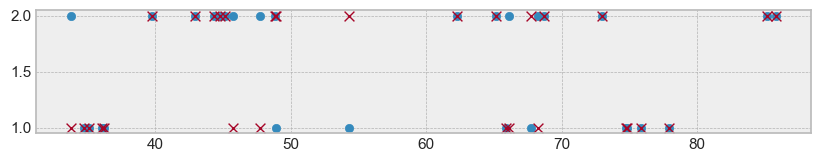

In [7]:
mdl= svm.SVC(C=10)

mdl.fit(X_train_sc,y_train)

#prediction
ypred=mdl.predict(X_test_sc)

mdl_acc=metrics.accuracy_score(y_test, ypred)

print("Scaled SVM Accuracy:",mdl_acc)

metrics.confusion_matrix(y_test,ypred)
print(ypred)
myplot(ypred)

# Cross-validation methods from sklearn

Cross validation is often used to "tune" hperparameters, but ... fundamentally ... it splits a KNOWN set of data, so that you can treat part of it as "unknown" and use it to *estimate performance on OTHER unknown data*.   (By "unknown", we mean not part of the training data.)

scikit learn has a number of methods for use to exam:

* cross_val_score
* cross_validate
* cross_val_predict
* validation_curve

There are a couple others that I am skipping in this demo.



## cross_val_score

Here we will instantiate a new model and evaluate at the same parameter setting.

We will use only the TRAINING data.   Our goal is to *ESTIMATE THE ACCURACY* of the model.   

* instantiate a model using C=10
* compute cross-validation scores using 10-fold cross validation
* Interpret the scores, with visualization

In [8]:
def myplot2(scores1):
    ax=sns.swarmplot(scores1,orient="h")
    ax.axvline(x=np.mean(scores1), color='r')
    ax.axvline(x=mdl_acc, color='g')
    ax.text(mdl_acc, .4, 'mdl_test_accuracy', rotation=90,color='g',fontdict={'size':10}
        , horizontalalignment='center')
    

[0.88888889 0.66666667 0.55555556 0.77777778 0.66666667 0.88888889
 0.66666667 0.75       0.625      0.625     ]
0.711111111111111 +/- 0.033781706642851884


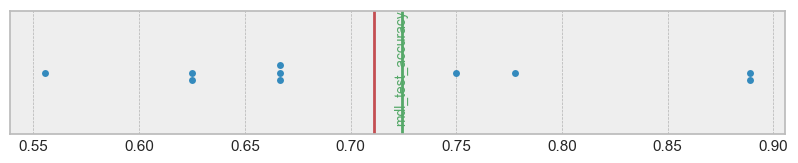

In [9]:
mdl1= svm.SVC(C=10)

scores1=ms.cross_val_score(mdl1,X_train_sc,y_train,cv=10)

print(scores1)
print(np.mean(scores1),"+/-",np.std(scores1)/np.sqrt(scores1.size))

myplot2(scores1)

The estimated (mean) accuracy of .71 with standard deviation of ~.035  is consistent with the test accuracy of .724 from above.

> Please note that when you run `cross_val_score` --- all you get is the scores from cross validation.   The model remains unfitted.

In [10]:
from sklearn.exceptions import NotFittedError
try:
    mdl1.predict(X_test_sc)
except NotFittedError as e:
    print(repr(e))


NotFittedError("This SVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.")


## cross_validate

The `cross_validate` does the same underlying fitting and evaluation operations, but yields a much richer set of return information.   You can check the help:

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate

to get a complete listing.   In particular, for this demo, I will ask it to return:




[0.88888889 0.66666667 0.55555556 0.77777778 0.66666667 0.88888889
 0.66666667 0.75       0.625      0.625     ]


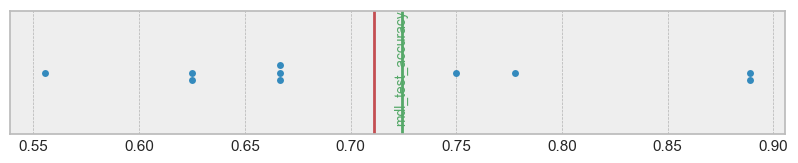

In [11]:
mdl2= svm.SVC(C=10)

res2=ms.cross_validate(mdl2,X_train_sc,y_train,cv=10,
                       return_train_score=True,
                       return_estimator=True)

scores2=res2['test_score']
print(scores2)

myplot2(scores2)

The returned object is actuall a dictionary, with a lot of different stuff.   

In [12]:
res2

{'fit_time': array([0.00299525, 0.00299501, 0.00199771, 0.00199676, 0.00199676,
        0.00199652, 0.00199699, 0.00199699, 0.00199676, 0.00200462]),
 'score_time': array([0.00099897, 0.00099826, 0.00099778, 0.00199747, 0.00099969,
        0.0009985 , 0.00099874, 0.00158978, 0.00109673, 0.00199676]),
 'estimator': [SVC(C=10),
  SVC(C=10),
  SVC(C=10),
  SVC(C=10),
  SVC(C=10),
  SVC(C=10),
  SVC(C=10),
  SVC(C=10),
  SVC(C=10),
  SVC(C=10)],
 'test_score': array([0.88888889, 0.66666667, 0.55555556, 0.77777778, 0.66666667,
        0.88888889, 0.66666667, 0.75      , 0.625     , 0.625     ]),
 'train_score': array([0.97435897, 0.97435897, 0.96153846, 0.96153846, 0.97435897,
        0.94871795, 0.96153846, 0.97468354, 0.98734177, 0.97468354])}

Let's inspect the `training score` for each model:

In [13]:
res2['train_score']

array([0.97435897, 0.97435897, 0.96153846, 0.96153846, 0.97435897,
       0.94871795, 0.96153846, 0.97468354, 0.98734177, 0.97468354])

These scores are all very high, nearly 100%, indicating probably on 1 or 2 observations misclassified, but *that number is on the observations on which the model was trained.


>Because we specified in the parameters, the method returns each of the models trained by the command (one for each fold). 


*Let's look at the model from the second fold*

Note - this submodel is fitted and is useable for predictions.  HOWEVER, it is a model created on a subset of a subset of the data, so not necessarily a model we want to use in an operational setting.

In [14]:
# extracting the model created while withholding the third fold
mdl2_1=res2['estimator'][1]

ypred2_2=mdl2_1.predict(X_test_sc)
print("Fold3 SVM Accuracy:",metrics.accuracy_score(y_test, ypred2_2))

metrics.confusion_matrix(y_test,ypred2_2)


Fold3 SVM Accuracy: 0.6896551724137931


array([[ 9,  3],
       [ 6, 11]], dtype=int64)

### cross_val_predict

The documentation for `cross-val_predict` method tells us 


>The data is split according to the cv parameter. Each sample belongs to exactly one test set, and >its prediction is computed with an estimator fitted on the corresponding training set.
>
>Passing these predictions into an evaluation metric may not be a valid way to measure >generalization performance. Results can differ from cross_validate and cross_val_score unless all >tests sets have equal size and the metric decomposes over samples.

*NOTE* - so ... not really useful for most of the usual applications, but it does allow us to visualize performance on those samples that are part of the training set while still allowing that the predictions were not done on the observations that were used to construct the model.


In [15]:
mdl3= svm.SVC(C=10)

# get a prediction for each training data point
ypred3=ms.cross_val_predict(mdl3,X_train_sc,y_train,cv=10)
# we compare these predictions against the true class of each of the training data observation
 
print("Training set cross-validated accuracy:",metrics.accuracy_score(y_train, ypred3))
metrics.confusion_matrix(y_train,ypred3)


Training set cross-validated accuracy: 0.7126436781609196


array([[28, 12],
       [13, 34]], dtype=int64)

Where this might be more interesting is where you assess the "surety" of these predictions by asking for probabilities to be output (instead of the class prediction).  The `predict` methods (in general) allow for these probabilities, though the source of that number (and its reliability) can be questionable, depending on the algorithm.    (Ask me about it some time.)

##### Predictions with probability assigned

In [16]:
mdl3_p= svm.SVC(C=10,probability=True)

yprobs3=ms.cross_val_predict(mdl3_p,X_train_sc,y_train,cv=10,method='predict_proba')
# we compare these predictions against the true class of each of the training data observation

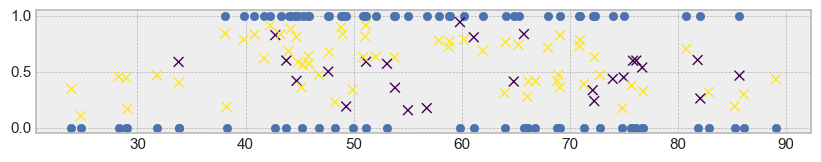

In [17]:
# A helper function for plotting
rng=np.random.default_rng(12345)
xvals_t = .7*rng.random(87)+X_train.Age-.35


y3_p_corr = (y_train==(1+(yprobs3[:,1]>0.5))) # was the prediction correct?

plt.rcParams['figure.figsize'] = [10, 1.6]
plt.style.use('bmh')
plt.scatter(xvals_t,y_train-1,color='b')
#plt.scatter(xvals_t,yprobs3[:,1],marker='x',s=50,linewidth=1,color='gold')
plt.scatter(xvals_t,yprobs3[:,1],marker='x',s=50,linewidth=1,
            c=y3_p_corr,cmap='viridis')

plt.show()

Age along horizontal, probability associated to each prediction is on vertical.  The blue circles are the "ground truth".   The "x's" colored purple indicate "Wrong" predictions.

### validation_curve

A primary use of cross validation is to choose hyperparameters.

The `validation_curve`   method allow us to explore a performance metric over a range of a (single) parameter value.  

> This functionality can provide a nice way to understand overfitting, at least with regard to a single variable.

We will look at three different paramter exporations:

* A range of gamma values, with C=10
* A range of gamma values, with C=10000
* A range of C values, with gamma set as default.

> The first cell creates another plotting function for this situation.


In [29]:
# a helper function to plot validation curves
def myplot3(train_scores,test_scores,param_range,param_name="gamma"):    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.title("Validation Curve with SVM")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(
        param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
    )
    plt.fill_between(
        param_range,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.2,
        color="darkorange",
        lw=lw,
    )
    plt.semilogx(
        param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
    )
    plt.fill_between(
        param_range,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.2,
        color="navy",
        lw=lw,
    )
    plt.legend(loc="best")
    plt.show()

plt.rcParams['figure.figsize'] = [10, 3]

##### C=10, vary parameter gamma

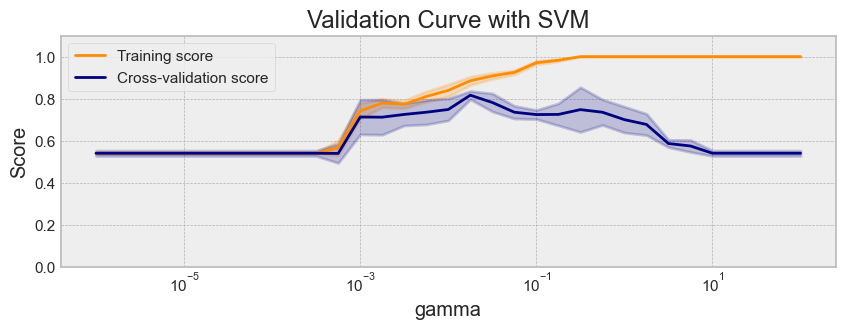

In [30]:
param_range = np.logspace(-6, 2, 33)

train_scores, test_scores = ms.validation_curve(
    svm.SVC(C=10),X_train_sc, y_train,
    param_name="gamma",param_range=param_range,scoring="accuracy")

myplot3(train_scores,test_scores,param_range)

Interpreting: small gamma means a simpler decision boundary (low variance), with "variance" increasing with gamma.  For very small gamma, the SVM can't do any better than classifying based on majority class.   At $\gamma \approx .001$, we final see change.  Increasing complexity will (almost) always make accuracy on the traing set increase, and cross-validation accuracy (on the samples held out on each fold) also gets better.   As we pass  $\gamma \approx .1$, we can see strong divergence between the accuracy on training vs evaluation, indicating that we are overfitting.

##### C=10000, ranging over gamma.

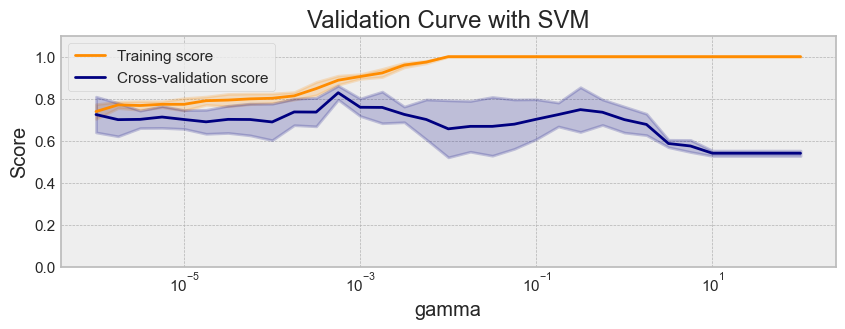

In [31]:
param_range = np.logspace(-6, 2, 33)
train_scores, test_scores = ms.validation_curve(
    svm.SVC(C=10000),X_train_sc, y_train,
    param_name="gamma",param_range=param_range,scoring="accuracy")

myplot3(train_scores,test_scores,param_range)

With a high value for C, we see not only a higher starting accuracy, but reach a slightly better cross-validation score peak.  We note the interaction of the parameters, in that the best gamma is now smaller for that larger value of C.

##### Exploring a range of C values, with gamma set at default


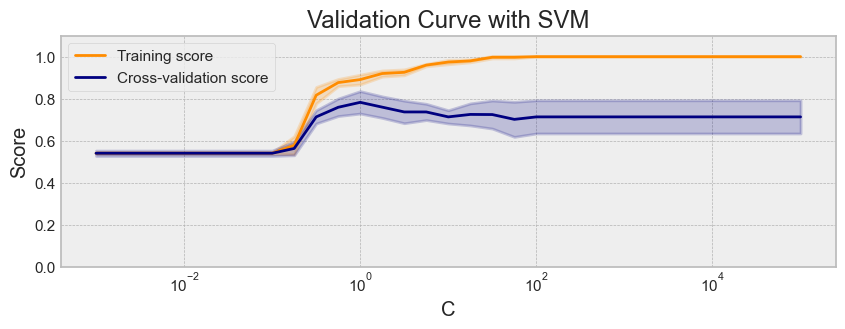

In [32]:
param_range = np.logspace(-3, 5, 33)
train_scores, test_scores = ms.validation_curve(
    svm.SVC(),    X_train_sc,    y_train,
    param_name="C",    param_range=param_range,    scoring="accuracy")

myplot3(train_scores,test_scores,param_range,"C")

Seems like (for the default gamma) that C should be approximately order 1.   Large C does seem to reduce the accuracy, though we note that it does not default to simply picking the majority class.  the implication --- it may be be exactly that it is overfitting, but it does worsen the generalization.  Those cases that can easily be separated ... are separated.